In [24]:
import torch
import torchvision
import torchvision.transforms as transforms
imageNetModel = torchvision.models.resnet18(pretrained = True)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [25]:
inputTensor = torch.rand((4,3,224,224))

print("Original-imageNetModel's output")
print(imageNetModel(inputTensor))

print("Recreated-imageNetModel's output")
recreatedModel = torch.nn.Sequential(*list(imageNetModel.children())[:-2])
print(recreatedModel(inputTensor).size())

#print(imageNetModel)


Original-imageNetModel's output
tensor([[-1.2203, -0.9134, -1.2386,  ..., -1.5340,  2.2545,  0.2027],
        [-1.1006, -0.0934, -2.3823,  ...,  0.5791,  1.1367,  0.3988],
        [ 0.3057,  1.1296,  2.8136,  ...,  0.0373, -1.2903,  0.0877],
        [-0.2329, -1.7075, -1.3320,  ..., -1.5365,  2.8195,  3.1354]],
       grad_fn=<AddmmBackward0>)
Recreated-imageNetModel's output
torch.Size([4, 512, 7, 7])


In [26]:
partialImageNetModel1 = torch.nn.Sequential(*list(imageNetModel.children())[:-5])
partialImageNetModel2 = torch.nn.Sequential(*list(imageNetModel.children())[:-4])
partialImageNetModel3 = torch.nn.Sequential(*list(imageNetModel.children())[:-3])
partialImageNetModel4 = torch.nn.Sequential(*list(imageNetModel.children())[:-2])
partialImageNetModels = [partialImageNetModel1, partialImageNetModel2, partialImageNetModel3, partialImageNetModel4]

In [27]:
print(partialImageNetModel2)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [28]:
for model in partialImageNetModels:
  for param in model.parameters():
    param.requires_grad = False

The cell below shows how to change a parameter in a convolution layer

In [29]:
convLayer = torch.nn.Conv2d(2,3,4)
print(convLayer.state_dict)
for (i, param) in enumerate(convLayer.parameters()):
  
  param.requires_grad = False
  print(param)

  if i == 0:
    print(param[0][0][0][0])
    param[0][0][0][0] = 9999
    print(param[0][0][0][0])
    param.requires_grad = True
    print("after changing a weight and resetting requires_grad = True")
    print(param)


<bound method Module.state_dict of Conv2d(2, 3, kernel_size=(4, 4), stride=(1, 1))>
Parameter containing:
tensor([[[[-0.1138, -0.1044,  0.1525, -0.1712],
          [ 0.0103,  0.1033, -0.1671,  0.0125],
          [ 0.0601,  0.0353,  0.0751, -0.0691],
          [-0.1127, -0.0354,  0.1218, -0.0909]],

         [[-0.0491,  0.0890, -0.0300,  0.1361],
          [-0.0490,  0.0593, -0.1272, -0.0713],
          [ 0.0541, -0.0329,  0.1210, -0.0791],
          [ 0.1708, -0.0358,  0.1743, -0.0354]]],


        [[[-0.0494, -0.0241,  0.0937,  0.0516],
          [-0.0335, -0.1217,  0.0063,  0.1393],
          [ 0.0134,  0.1295, -0.0998, -0.0077],
          [-0.1034,  0.1477,  0.1242, -0.0204]],

         [[-0.1014,  0.1084, -0.0279, -0.0648],
          [-0.1219,  0.1225, -0.1576,  0.0109],
          [-0.1324,  0.0216, -0.1759, -0.0285],
          [-0.0882, -0.0245,  0.1535, -0.0441]]],


        [[[-0.0106,  0.0719,  0.0983,  0.0281],
          [ 0.1503,  0.1462,  0.1660,  0.1162],
          [ 0.1702

In the cell below, we are going to try to create a new convolution layer N1 (that takes as input nC1 channels), from another one N2 (that takes as input nC2 channels); such that N1 copies the parameters from N2; and sets its kernel weights to 0 for (nC1 - nC2) incomming channels. This is the procedure that needs to be implemented when we replace a specific layer in the Simple Network (the one that takes as input the ImageNet network)

In [30]:
layerToReplace = torch.nn.Conv2d(2,3,4)
newLayer = torch.nn.Conv2d(3,3,4)

print("newLayer biases before change")
print(newLayer.state_dict()["bias"])

listOfParameters = []
for param in newLayer.parameters():
  param.requires_grad = False
  listOfParameters.append(param)

listOfParameters[0][:,:,:,:] = torch.zeros((3,3,4,4))
listOfParameters[0][:,1:,:,:] = layerToReplace.state_dict()["weight"]

listOfParameters[1][:] = layerToReplace.state_dict()["bias"]

print("newLayer biases after change")
print(newLayer.state_dict()["bias"])

for param in newLayer.parameters():
  param.requires_grad = True


print("layerToReplace Biases")
print(layerToReplace.state_dict()["bias"])

newLayer biases before change
tensor([ 0.0283, -0.0306, -0.0977])
newLayer biases after change
tensor([ 0.0006, -0.1388, -0.1185])
layerToReplace Biases
tensor([ 0.0006, -0.1388, -0.1185])


In the cell below we do the right concatenation of the output of the lower parts of the ImageNet network and the Simple Network

In [31]:
outputFromLowerLayersOfImageNet = torch.rand((1,10,10))
outputFromLowerLayersOfSimpleNetwork = torch.rand((2,10,10))

#Below is the right order in which to do the concatenation:
inputTensorToTheNewLayer = torch.cat([outputFromLowerLayersOfImageNet, outputFromLowerLayersOfSimpleNetwork])

#Below is the wrong order in which to do the concatenation:
#inputTensorToTheNewLayer = torch.cat([outputFromLowerLayersOfSimpleNetwork, outputFromLowerLayersOfImageNet])

print("Output from intermediate network before the change")
print(layerToReplace(outputFromLowerLayersOfSimpleNetwork))

print("Output from intermediate network after the change")
print(newLayer(inputTensorToTheNewLayer))



Output from intermediate network before the change
tensor([[[-0.1154,  0.2177, -0.1201,  0.2269,  0.0644, -0.1625,  0.2312],
         [ 0.1155, -0.2781, -0.2690,  0.0798, -0.2812, -0.1034, -0.1781],
         [-0.1159, -0.1781, -0.0622, -0.1370, -0.1824, -0.0233, -0.1408],
         [ 0.0865,  0.0282,  0.0849, -0.0512,  0.1036, -0.1275, -0.0855],
         [-0.1711,  0.1151, -0.3047,  0.1598, -0.0197, -0.2013,  0.2158],
         [-0.0241, -0.0924,  0.0967, -0.0339, -0.0683, -0.1232, -0.4850],
         [ 0.0443, -0.1059, -0.0187, -0.1164, -0.3439, -0.0426, -0.2578]],

        [[ 0.1554, -0.1286, -0.0681,  0.0878,  0.1427, -0.0650,  0.0046],
         [ 0.0493, -0.0502,  0.3071,  0.0939,  0.0907,  0.2917,  0.0873],
         [-0.0352,  0.2755,  0.2845, -0.0653,  0.4541,  0.0753,  0.0803],
         [ 0.0062,  0.1752, -0.1503,  0.1408,  0.0853,  0.0457,  0.0719],
         [-0.1084,  0.0674,  0.1488,  0.2202,  0.0028, -0.0031, -0.0589],
         [ 0.2742, -0.0423,  0.0495,  0.1257, -0.0941,  0.0

In [32]:
def outputSizeOfLowerLayers(lowerLayers, testImage):
    return lowerLayers(testImage).size()

class MergedNetwork(torch.nn.Module):

    def __init__(self, lowerLayersOfImageNet, lowerLayersOfSimpleModel, upperLayersOfSimpleModel, layerOfSimpleModelToBeReplaced, specificationsOfLayerToBeReplaced, batchSize):
        super(MergedNetwork, self).__init__()
        self.lowerLayersOfImageNet = lowerLayersOfImageNet
        self.lowerLayersOfSimpleModel = lowerLayersOfSimpleModel
        self.upperLayersOfSimpleModel = upperLayersOfSimpleModel

        #Cifar10 Images are 32 by 32 with 3 channels (I think (the color channels))
        self.outputSizeValuesOfLowerLayersOfSimpleModel = outputSizeOfLowerLayers(lowerLayersOfSimpleModel, torch.zeros((batchSize,3,32,32)))


        #the ImageNet network is ResNet18 which takes as input 224 by 244 images with 3 channels
        self.outputSizeValuesOfLowerLayersOfImageNetModel = outputSizeOfLowerLayers(lowerLayersOfImageNet, torch.zeros((batchSize,3,224,224)))
        
        #In the following, the index value of (1) should be the number of channels.
        numberOfOutputChannelsOfLowerLayersOfImageNetModel = self.outputSizeValuesOfLowerLayersOfImageNetModel[1]
        self.numberOfInputChannelsInNewMergingLayer = self.outputSizeValuesOfLowerLayersOfSimpleModel[1] + numberOfOutputChannelsOfLowerLayersOfImageNetModel

        ###########################################################################################
        #We construct below the new convolution layer
        outNumberOfChannels = specificationsOfLayerToBeReplaced["outChannels"]
        kernelSize = specificationsOfLayerToBeReplaced["kernelSize"]
        padding = specificationsOfLayerToBeReplaced["padding"]
        self.newConvolutionLayer = torch.nn.Conv2d(self.numberOfInputChannelsInNewMergingLayer, outNumberOfChannels, kernelSize, padding = padding)

        listOfParameters = []
        for param in self.newConvolutionLayer.parameters():
          param.requires_grad = False
          listOfParameters.append(param)

        listOfParameters[0][:,:,:,:] = torch.zeros((outNumberOfChannels, self.numberOfInputChannelsInNewMergingLayer, kernelSize, kernelSize))
        listOfParameters[0][:, numberOfOutputChannelsOfLowerLayersOfImageNetModel:,:,:] = layerOfSimpleModelToBeReplaced.state_dict()["weight"]
        listOfParameters[1][:] = layerOfSimpleModelToBeReplaced.state_dict()["bias"]

        for param in self.newConvolutionLayer.parameters():
          param.requires_grad = True

        ###########################################################################################
        #Becareful here! We don't want to interpolate in the channel dimension!
        targetFeatureMapWidth = self.outputSizeValuesOfLowerLayersOfSimpleModel[2]
        targetFeatureMapHeight = self.outputSizeValuesOfLowerLayersOfSimpleModel[3]
        self.targetShapeOfImageNetOutput = (targetFeatureMapWidth, targetFeatureMapHeight)


    def forward(self, x):
        #The ImageNet model (ResNet18) takes as input 224 by 224 images (with 3 channels).
        #Cifar10 Images are 32 by 32 and are color images, so have 3 channels (I think).
        inputToImageNet = F.interpolate(x, size = (224, 224))
        lowerLayersImageNetOutput = self.lowerLayersOfImageNet(inputToImageNet)

        #Becareful here! We don't want to interpolate in the channel dimension!
        lowerLayersImageNetOutput = F.interpolate(lowerLayersImageNetOutput, size = self.targetShapeOfImageNetOutput, mode = "bilinear")

        lowerLayersSimpleModelOutput = self.lowerLayersOfSimpleModel(x)

        #Below is the right order in which to do the concatenation:
        inputTensorToTheNewLayer = torch.cat([lowerLayersImageNetOutput, lowerLayersSimpleModelOutput], dim = 1)

        outputOfNewLayer = self.newConvolutionLayer(inputTensorToTheNewLayer)

        return self.upperLayersOfSimpleModel(outputOfNewLayer)

In [33]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


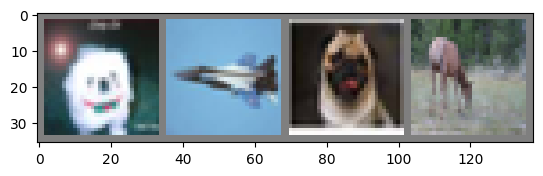

dog   plane dog   deer 


In [34]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

Take the model from: https://github.com/Xinyi6/CIFAR10-CNN-by-Keras/blob/master/lic/model2_3.ipynb


model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(80))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

I think the "Dense" layer in Tensorflow is just a linear layer. The parameter of the "Dense" layer is the "out_features" parameter of the linear layer in PyTorch. In TensorFlow, you don't need to specify the dimension of the input in a linear layer. You also don't need to specify the number of channels in a convolution layer. In either cases, they are implicitly specified by the previous layer.

In [35]:
#Below is the __init__ method written such that the .module() method returns the layers in the right order; as to recreate what is spelled out by the forward method

import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, 3, padding = "same")
        self.relu1 = F.relu
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(p = 0.3)

        self.conv2 = nn.Conv2d(32, 64, 3, padding = "same")
        self.relu2 = F.relu
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(p = 0.3)

        self.conv3 = nn.Conv2d(64, 128, 3, padding = "same")
        self.relu3 = F.relu
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout(p = 0.4)

        self.conv4 = nn.Conv2d(128, 256, 3, padding = "same")
        self.relu4 = F.relu
        self.pool4 = nn.MaxPool2d(2, 2)
        self.dropout4 = nn.Dropout(p = 0.4)


        self.conv5 = nn.Conv2d(256, 512, 3, padding = "same")
        self.relu5 = F.relu
        self.pool5 = nn.MaxPool2d(2, 2)
        self.dropout5 = nn.Dropout(p = 0.4)

        self.flatten = nn.Flatten()

        self.linear1 = nn.Linear(512, 80)
        self.relu6 = F.relu
        self.dropout6 = nn.Dropout(p = 0.3)

        self.linear2 = nn.Linear(80, 20)

    def forward(self, x):

        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.dropout2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = self.dropout3(x)

        x = self.conv4(x)
        x = self.relu4(x)
        x = self.pool4(x)
        x = self.dropout4(x)

        x = self.conv5(x)
        x = self.relu5(x)
        x = self.pool5(x)
        x = self.dropout5(x)

        x = self.flatten(x)

        x = self.linear1(x)
        x = self.relu6(x)
        x = self.dropout6(x)

        x = self.linear2(x)
        
        return x


simpleModel = Net()

In [36]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(simpleModel.parameters(), lr=0.001, momentum=0.9)

In [41]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = simpleModel(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 234.679
[1,  4000] loss: 225.394
[1,  6000] loss: 204.046
[1,  8000] loss: 192.756
[1, 10000] loss: 186.694
[1, 12000] loss: 182.411
[2,  2000] loss: 173.501
[2,  4000] loss: 169.180
[2,  6000] loss: 165.459
[2,  8000] loss: 161.327
[2, 10000] loss: 154.955
[2, 12000] loss: 152.260
Finished Training


In [42]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = simpleModel(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 45 %


In [44]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = reconstructedSimpleModel(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 44 %


The reconstruction of the simpleModel as done below gives the same accuracy as the original model. So the reconstruction is really done right; you really need to add the ReLU activation functions by hand between the Conv2d layers and the Linear layers.

In [43]:


numberOfChildren = len(list(simpleModel.children()))
listOfChildren = []
for (i, child) in enumerate(simpleModel.children()):
  #print(i)
  listOfChildren.append(child)
  if((isinstance(child, nn.Conv2d) or isinstance(child, nn.Linear)) and (i < numberOfChildren - 1)):
    listOfChildren.append(nn.ReLU())
print(listOfChildren)
reconstructedSimpleModel = torch.nn.Sequential(*listOfChildren)


# for (children1, children2) in zip(simpleModel.children(), reconstructedSimpleModel.children()):
#   for (param1, param2) in zip(children1.parameters(), children2.parameters()):
#     print(torch.all(torch.eq(param1, param2)))

# print("Some parameters of the last layer of simpleModel")
# for param1 in params1:
#   print(param1)
# print("Some parameters of the last layer of the reconstruction of simpleModel")
# for param2 in params2:
#   print(param2)

[Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same), ReLU(), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Dropout(p=0.3, inplace=False), Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same), ReLU(), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Dropout(p=0.3, inplace=False), Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same), ReLU(), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Dropout(p=0.4, inplace=False), Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same), ReLU(), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Dropout(p=0.4, inplace=False), Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=same), ReLU(), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Dropout(p=0.4, inplace=False), Flatten(start_dim=1, end_dim=-1), Linear(in_features=512, out_features=80, bias=True), ReLU(), 

The ReLU activation functions get discarded in the reconstruction of the simpleModel network (I think). As the code above shows, all values of the parameters are equal. The ReLU activation functions are not part of the children of the network, so they don't get transfered to the reconstruction of simpleModel. This is why I was getting results that showed values of a different order of magnitude (about may be 10 times), when passing a tensor, to the reconstructed network and the original network.

In [ ]:


inputTensor = torch.ones((4,3,32,32))

print(simpleModel(inputTensor))
print(inputTensor.size())
print(reconstructedSimpleModel(inputTensor))


tensor([[ 4.5820,  0.4644,  3.1070,  0.8278,  2.1320,  0.5174,  0.5390,  0.8805,
          4.5138,  1.1418, -2.2141, -1.8552, -1.5743, -1.9809, -2.3326, -2.0321,
         -2.1287, -1.9607, -2.1834, -2.2320],
        [ 4.8618,  1.6431,  3.6598,  1.2052,  2.0208,  0.1352,  1.0238,  0.2552,
          5.6455,  1.9371, -2.3522, -2.3489, -1.9945, -2.8763, -2.1203, -2.5912,
         -2.4761, -2.4975, -2.6342, -2.3030],
        [ 5.1173,  2.0956,  4.1487,  2.2261,  2.3065,  1.0937,  2.0035,  0.1702,
          6.7570,  2.0406, -2.8460, -3.0535, -2.5528, -3.3604, -2.6004, -3.2474,
         -3.2761, -3.2111, -3.0593, -2.7875],
        [ 5.2180, -0.7999,  4.6917,  2.5948,  3.3590,  2.4468,  1.2543,  1.8520,
          4.2601, -0.6171, -2.4455, -2.6407, -2.1782, -2.6511, -2.3869, -2.5555,
         -3.1032, -2.8170, -2.7282, -2.3243]], grad_fn=<AddmmBackward0>)
torch.Size([4, 3, 32, 32])
tensor([[ 3.8858,  0.8876,  3.7844,  2.3139,  2.2045,  1.5083,  1.3330,  1.0247,
          4.4412,  1.1955, -2.306

Below we are going to select lower parts and upper parts and the layers to be replaced of the simpleModel network

In [45]:
numberOfChildren = len(list(simpleModel.children()))

partsOfSimpleModellist = []


for layerToBeReplacedNumber in range(1,5):

  lowerLayers = []
  upperLayers = []
  
  skipChild = False
  convolutionLayerNumberOrPlusOne = 0
  for (childNumber, child) in enumerate(simpleModel.children()):

    if(isinstance(child, nn.Conv2d) and (childNumber > 0)):
      convolutionLayerNumberOrPlusOne = convolutionLayerNumberOrPlusOne + 1

      if(convolutionLayerNumberOrPlusOne == layerToBeReplacedNumber):
        layerToBeReplaced = child
        skipChild = True
        convolutionLayerNumberOrPlusOne = convolutionLayerNumberOrPlusOne + 1

    if(convolutionLayerNumberOrPlusOne > layerToBeReplacedNumber):
      
      if(skipChild == False):
        upperLayers.append(child)

      if((isinstance(child, nn.Conv2d) or isinstance(child, nn.Linear)) and (childNumber < numberOfChildren - 1)):
        upperLayers.append(nn.ReLU())

    elif((convolutionLayerNumberOrPlusOne < layerToBeReplacedNumber) and (skipChild == False)):
      lowerLayers.append(child)

      if((isinstance(child, nn.Conv2d) or isinstance(child, nn.Linear)) and (childNumber < numberOfChildren - 1)):
        lowerLayers.append(nn.ReLU())

    skipChild = False
    
    

  partsOfSimpleModellist.append({})
  partsOfSimpleModellist[layerToBeReplacedNumber - 1]["Lower Layers"] = torch.nn.Sequential(*lowerLayers)
  partsOfSimpleModellist[layerToBeReplacedNumber - 1]["Upper Layers"] = torch.nn.Sequential(*upperLayers)
  partsOfSimpleModellist[layerToBeReplacedNumber - 1]["Layer to be replaced"] = layerToBeReplaced

print(simpleModel)
print(partsOfSimpleModellist[2]["Lower Layers"])
print(partsOfSimpleModellist[2]["Upper Layers"])
print(partsOfSimpleModellist[2]["Layer to be replaced"])

for partsOfSimpleModelIndex in range(4):
  for child in partsOfSimpleModellist[partsOfSimpleModelIndex]["Lower Layers"]:
    for param in child.parameters():
      param.requires_grad = False

  for child in partsOfSimpleModellist[partsOfSimpleModelIndex]["Upper Layers"]:
    for param in child.parameters():
      param.requires_grad = False

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.3, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.3, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.4, inplace=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout4): Dropout(p=0.4, inplace=False)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout

In [46]:
specificationsOfLayerToBeReplaced = {}
specificationsOfLayerToBeReplaced["outChannels"] = 256
specificationsOfLayerToBeReplaced["kernelSize"] = 3
specificationsOfLayerToBeReplaced["padding"] = "same"

someMergedNetwork = MergedNetwork(partialImageNetModels[2], partsOfSimpleModellist[2]["Lower Layers"], partsOfSimpleModellist[2]["Upper Layers"], partsOfSimpleModellist[2]["Layer to be replaced"], specificationsOfLayerToBeReplaced, 4)

 

In [47]:
someMergedNetwork(torch.ones(4, 3, 32, 32))

tensor([[ 4.6958e+00, -1.0493e+00,  5.3003e+00,  3.7899e+00,  3.6130e+00,
          3.4103e+00,  1.5737e+00,  9.8253e-01,  4.4863e+00, -7.6039e-02,
         -2.5231e+00, -2.5379e+00, -2.5406e+00, -2.5712e+00, -2.6376e+00,
         -2.8253e+00, -2.9916e+00, -2.0888e+00, -2.4733e+00, -2.8049e+00],
        [ 4.8533e+00, -4.1061e-01,  5.5880e+00,  4.1840e+00,  3.3369e+00,
          4.0043e+00,  1.0619e+00,  1.6187e+00,  4.5576e+00,  1.7279e-01,
         -2.5940e+00, -2.7705e+00, -2.7413e+00, -2.8818e+00, -2.3102e+00,
         -2.8840e+00, -3.2427e+00, -2.1539e+00, -2.4797e+00, -2.6694e+00],
        [ 4.1516e+00,  1.1013e-03,  4.7613e+00,  3.7019e+00,  3.5735e+00,
          3.3127e+00,  2.3300e+00,  1.4872e+00,  3.4012e+00,  2.8641e-01,
         -3.0192e+00, -2.9382e+00, -2.7155e+00, -2.6649e+00, -3.0450e+00,
         -2.8677e+00, -2.9625e+00, -2.4869e+00, -2.2526e+00, -2.7258e+00],
        [ 4.6142e+00,  2.2278e-01,  5.1579e+00,  3.2604e+00,  3.5371e+00,
          3.1772e+00,  1.6931e+00, 

In [50]:
simpleModel(torch.ones(4,3,32,32))

tensor([[ 4.6148, -0.1527,  5.4538,  4.3333,  3.5902,  3.8770,  1.8116,  1.6738,
          4.8480,  0.6237, -3.4249, -3.2900, -3.0724, -3.3043, -3.2290, -3.1719,
         -3.6515, -2.5477, -2.6850, -2.9324],
        [ 4.1938, -0.5240,  4.6096,  3.0852,  2.6833,  2.6568,  1.2157,  0.4015,
          4.5467,  0.1097, -2.2917, -2.2084, -2.3820, -2.3441, -2.4080, -2.3942,
         -2.8386, -1.7390, -1.8273, -2.3973],
        [ 4.3183, -1.5632,  5.6547,  3.9488,  4.0173,  3.5278,  2.0120,  0.7317,
          3.4191, -0.6248, -2.0849, -2.0308, -2.4771, -2.3251, -2.4712, -2.2181,
         -2.5568, -1.8424, -1.9825, -2.2541],
        [ 4.2617, -0.2148,  5.5542,  4.7587,  3.9762,  4.5425,  2.5437,  2.0424,
          3.8375,  0.3250, -3.2171, -3.0290, -2.9726, -3.3927, -3.1424, -3.0821,
         -3.3394, -2.3328, -2.5943, -3.0754]])

Below we verify that the accuracy of the merged network is the same as the accuracy of the original network. Because the merged network does not take at this point any input from the lower part of the ImageNet network

In [54]:
correct = 0
total = 0
index = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = someMergedNetwork(images)
        # the class with the highest energy is what we choose as prediction
        if(index % 100 == 99):
          print("index: ", index)
        index = index + 1
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

index:  99
index:  199
index:  299
index:  399
index:  499
index:  599
index:  699
index:  799
index:  899
index:  999
index:  1099
index:  1199
index:  1299
index:  1399
index:  1499
index:  1599
index:  1699
index:  1799
index:  1899
index:  1999
index:  2099
index:  2199
index:  2299
index:  2399
index:  2499
Accuracy of the network on the 10000 test images: 44 %
